# DNN Model for One Particle in Harmonic Oscillator

In [1]:
import sys
sys.path.append("..")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from system import *

In [2]:
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx("float64")

%load_ext autoreload
%autoreload 2

def saveto(fig, path, ncol=2):
    lgd = fig.legend(loc='lower left',# mode='expand',-
                     ncol=ncol,
                     bbox_to_anchor=(0.1, 1.02, 1, 0.2))
    fig.savefig(f"../latex/figures/{path}.pdf", bbox_inches='tight') 

In [3]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [4]:
class Ansatz(tf.keras.Model):
    def __init__(self, nodes, activation = "tanh"):
        super().__init__()
        self.activation = activation
        
        self.Layers = []
        for node in nodes:
            self.Layers.append(tf.keras.layers.Dense(node))
    
        self.out = tf.keras.layers.Dense(1)

    def call(self, x):
        for layer in self.Layers:
            if self.activation == "tanh":
                x = tf.math.tanh(layer(x))
            
            if self.activation == "relu":
                x = tf.nn.relu(layer(x))
                
        return tf.math.exp(self.out(x))   
    
  
@tf.function
def loss(system, x):
    batch_size = x.shape[1]
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]


    psi = system.Ansatz(_x2)
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(batch_size):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    K_L = -0.5*d2_psi/psi
    
    E_L = K_L + system.External(x) 
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    loss_value = 2*(tf.math.reduce_mean(tf.math.log(psi)*E_L) - tf.math.reduce_mean(tf.math.log(psi))*E)
    
    return E, loss_value, E_L, K_L


@tf.function
def grad(system, x):
    with tf.GradientTape() as tape:
        E, loss_value, _, _  = loss(system, x)

    return E, tape.gradient(loss_value, system.Ansatz.trainable_variables)


def train(system, num_epochs, batch_size, optimizer, verbose = True):
    energy = []
    
    for epoch in tqdm(range(num_epochs)):
        x = system.Sampler(batch_size)[0]

        E, gradients = grad(system, x)
        energy.append(E)

        optimizer.apply_gradients(zip(gradients, system.Ansatz.trainable_variables))
        
        if verbose:
            if epoch%100 == 0: 
                print(f"epoch: {epoch}, Energy: {E}")
    
    return energy


def observables(system, batch_size, x = None):
    if (x == None):
        x = system.Sampler(batch_size)
    
    _, _, E_L, K_L = loss(system, x)
    E = tf.math.reduce_mean(E_L).numpy()
    E2 = tf.math.reduce_mean(E_L**2).numpy()
    Var = E2 - E**2
    return E, Var, K_L


optimizer = tf.keras.optimizers.Adam(0.01)

## 1D

### Smooth activation function (tanh)

#### Model paramters

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (32, 32))
external = HarmonicOsc(1)
sampler = Metropolis(1.5, 20)

system = System(num_part = 1,
                 dim = 1,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

#### Training

In [6]:
num_epochs = 500
batch_size = 500

energy1 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 10.015391488926234
epoch: 100, Energy: 0.5301368885011893
epoch: 200, Energy: 0.5028966965491962
epoch: 300, Energy: 0.5034162019582591
epoch: 400, Energy: 0.4980848812136077



In [7]:
tf.random.set_seed(42)
np.random.seed(42)

N = 100000
_, accepted = system.Sampler(N)
print(f"{accepted/(20*N)}")

0.6129265


In [8]:
x = tf.convert_to_tensor(np.linspace(-5, 5, 1000).reshape(-1,1), dtype=tf.dtypes.float64)
dx = x[1] - x[0]

psi1 = system.Ansatz(x).numpy()
psi1 *= np.sqrt(1/(dx*np.sum(psi1**2)))
psi_analytical = np.pi**(-0.25)*np.exp(-0.5*x**2)

_, _, _, K_L1 = loss(system, x)
K_L_analytical = 0.5 - 0.5*x**2 

#### Numerical vs Analytical Wave Function

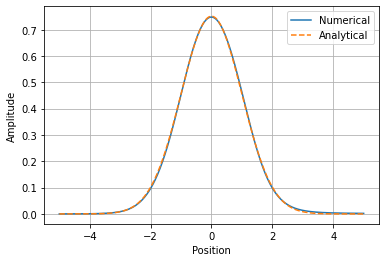

In [9]:
fig = plt.figure()
plt.plot(x, psi1)
plt.plot(x, psi_analytical, "--")
plt.legend(["Numerical", "Analytical"])
plt.xlabel("Position")
plt.ylabel("Amplitude")
plt.grid()

plt.show()

#### Local Kinetic Energy Using Tanh as Activation

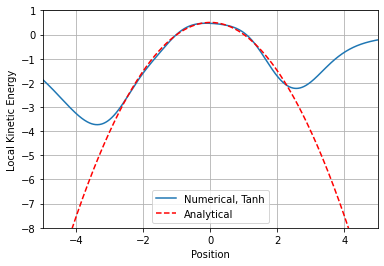

In [10]:
fig = plt.figure()
plt.plot(x, K_L1)
plt.plot(x, K_L_analytical, "r--")
plt.xlabel("Position")
plt.ylabel("Local Kinetic Energy")
plt.legend(["Numerical, Tanh", "Analytical"])
plt.ylim([-8,1])
plt.xlim([-5,5])
plt.grid()
plt.show()

#### Ground state energy

In [11]:
N = 1000000
x, _ = system.Sampler(N)
E, Var, _ = observables(system, N, x)
print(f"Energy: {E}+-{np.sqrt(Var/N)}")
print("Var: ", Var)

Energy: 0.5009482032016668+-0.00011937980433049225
Var:  0.014251537681986615


# Testing Relu activation

#### Model Parameters

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes, activation = "relu")
external = HarmonicOsc(1)
sampler = Metropolis(1.5, 20)

system = System(num_part = 1,
                 dim = 1,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

#### Training

In [13]:
num_epochs = 500
batch_size = 500

energy2 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 9.000935735083672
epoch: 100, Energy: 0.12690611314203093
epoch: 200, Energy: -0.26986492317561966
epoch: 300, Energy: -0.1050733589013267
epoch: 400, Energy: -0.13162748446002903



No handles with labels found to put in legend.


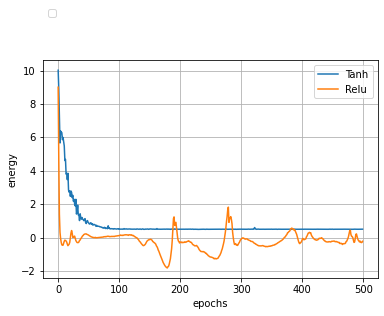

In [14]:
fig = plt.figure()
plt.plot(energy1)
plt.plot(energy2)
plt.xlabel("epochs")
plt.ylabel("energy")
plt.legend(["Tanh","Relu"])
plt.grid()
saveto(fig, "one_part_training1", ncol=2)

plt.show()

In [15]:
x = tf.convert_to_tensor(np.linspace(-5, 5, 1000).reshape(-1,1), dtype=tf.dtypes.float64)
dx = x[1] - x[0]

psi2 = system.Ansatz(x).numpy()
psi2 *= np.sqrt(1/(dx*np.sum(psi2**2)))

_, _, _, K_L2 = loss(system, x)
K_L_analytical = 0.5 - 0.5*x**2 

#### Numerical vs Analytical Wave Function

No handles with labels found to put in legend.


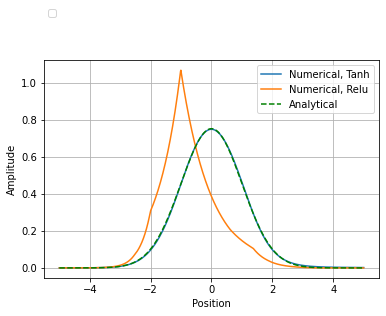

In [16]:
fig = plt.figure()
plt.plot(x, psi1)
plt.plot(x, psi2)
plt.plot(x, psi_analytical, "g--")
plt.legend(["Numerical, Tanh", "Numerical, Relu",  "Analytical"])
plt.xlabel("Position")
plt.ylabel("Amplitude")
plt.grid()
saveto(fig, "one_part_wavefunc", ncol=2)

plt.show()

#### Local Kinetic Energy Using Tanh vs Relu

No handles with labels found to put in legend.


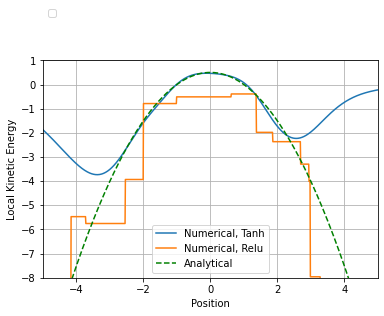

In [17]:
fig = plt.figure()
plt.plot(x, K_L1)
plt.plot(x, K_L2)
plt.plot(x, K_L_analytical, "g--")
plt.xlabel("Position")
plt.ylabel("Local Kinetic Energy")
plt.legend(["Numerical, Tanh", "Numerical, Relu", "Analytical"])
plt.ylim([-8,1])
plt.xlim([-5,5])
plt.grid()

saveto(fig, "one_part_local_kinetic", ncol=2)
plt.show()

#### Ground State Energy

In [18]:
N = 1000000
x, _ = system.Sampler(N)
E, Var, _ = observables(system, N, x)
print(f"Energy: {E}+-{np.sqrt(Var/N)}")
print("Var: ", Var)

Energy: -0.13289547966225643+-0.00037897846116095613
Var:  0.1436246740239263


## 2D

#### Model Parameters

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes)
external = HarmonicOsc(1)
sampler = Metropolis(1, 20)

system = System(num_part = 1,
                 dim = 2,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [20]:
num_epochs = 500
batch_size = 500

energy1 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 7.8405731216775205
epoch: 100, Energy: 1.001446949834111
epoch: 200, Energy: 1.0041219334164606
epoch: 300, Energy: 1.0008306968129774
epoch: 400, Energy: 1.00779653161216



In [21]:
tf.random.set_seed(42)
np.random.seed(42)

N = 100000
_, accepted = system.Sampler(N)
print(f"{accepted/(20*N)}")

0.5946055


In [22]:
bins = np.linspace(0, 3, 100)
density = oneBodyDensity(x, bins, mode = "radial2D")/N
density_analytical = 1/np.pi*np.exp(-bins**2)

No handles with labels found to put in legend.


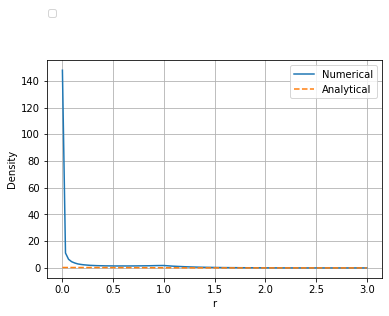

In [23]:
fig = plt.figure()
plt.plot(bins, density)
plt.plot(bins, density_analytical, "--")
plt.xlabel("r")
plt.ylabel("Density")
plt.legend(["Numerical","Analytical"])
plt.grid()
saveto(fig, "one_part_2D_dens", ncol=2)

plt.show()

## 3D

#### Model Parameters

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

nodes = (32, 32)

ansatz = Ansatz(nodes)
external = HarmonicOsc(1)
sampler = Metropolis(1, 20)

system = System(num_part = 1,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=None,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)

#### Training

In [31]:
num_epochs = 500
batch_size = 500

energy2 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 11.20739719256565
epoch: 100, Energy: 1.5203512391568046
epoch: 200, Energy: 1.5221706091990896
epoch: 300, Energy: 1.5083389862439984
epoch: 400, Energy: 1.4999072354628369



No handles with labels found to put in legend.


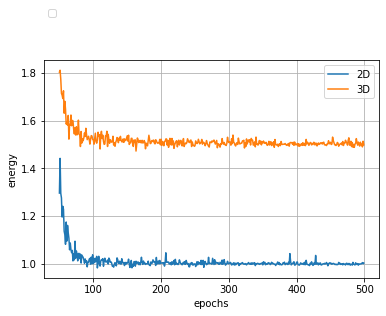

In [34]:
fig = plt.figure()
plt.plot(np.arange(50,500), energy1[50:])
plt.plot(np.arange(50,500), energy2[50:])
plt.xlabel("epochs")
plt.ylabel("energy")
plt.legend(["2D","3D"])
plt.grid()
saveto(fig, "one_part_training3", ncol=2)

plt.show()

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

N = 100000
_, accepted = system.Sampler(N)
print(f"{accepted/(20*N)}")

In [ ]:
bins = np.linspace(0, 3, 100)
density = oneBodyDensity(x, bins, mode = "radial3D")/N
density_analytical = 1/(2*np.pi)*np.exp(-bins**2)

In [ ]:
fig = plt.figure()
plt.plot(bins, density)
plt.plot(bins, density_analytical, "--")
plt.xlabel("r")
plt.ylabel("Density")
plt.legend(["Numerical","Analytical"])
plt.grid()
saveto(fig, "one_part_3D_dens", ncol=2)

plt.show()